# Introduction

In the previous notebook we prepared data for training our model. In this notebook we will create our model, then train the model and then evaluate it.

# Importing the data

We have already our data in the previous section in this section we will just download the data and decompress them. All the files used in this notebook are stored as publicly downloadable file.

## Downloading data.

In [1]:
# Download clean images
!gdown https://drive.google.com/uc?id=1-CNOtMEBdZna6m5fB9WOjXyGqAcMyor9

Downloading...
From: https://drive.google.com/uc?id=1-CNOtMEBdZna6m5fB9WOjXyGqAcMyor9
To: /content/testSetPlaces205_resize.tar.gz
2.34GB [00:27, 85.8MB/s]


In [2]:
# Download dirty images
!gdown https://drive.google.com/uc?id=1svg85MYow-kaOLk0Z_W4GS3LwShDrg2C

Downloading...
From: https://drive.google.com/uc?id=1svg85MYow-kaOLk0Z_W4GS3LwShDrg2C
To: /content/dirty_images.zip
1.51GB [00:35, 42.8MB/s]


## Decompressing data.

In [ ]:
# decompressing the clean image file.
!gunzip < testSetPlaces205_resize.tar.gz | tar xvf -

# reanaming the directory.
!mv /content/testSet_resize /content/clean_images

In [4]:
# decompressing dirty image file
!unzip dirty_images.zip

Streaming output truncated to the last 5000 lines.
  inflating: dirty_images/e38ac54927e7f3017ef01774e5a2e579.jpg  
  inflating: dirty_images/dcdba5ee4521fc205121b905fba66033.jpg  
  inflating: dirty_images/97659404cc7caee367655ee04ab9b241.jpg  
  inflating: dirty_images/fd2dd7a56e67bb6cb125e0516e50d2d2.jpg  
  inflating: dirty_images/b567ba7d637327be7d40313b2b8f391a.jpg  
  inflating: dirty_images/6e7dc3c7d69030904c599b5f2c8c342e.jpg  
  inflating: dirty_images/2719de7bdd886279442f720404e9177d.jpg  
  inflating: dirty_images/44e96d3ea746130392d948af012de0f3.jpg  
  inflating: dirty_images/97fbf795be8d1c0835c903cfd49a75e2.jpg  
  inflating: dirty_images/1f71b4200a2654ea45b87d1183a7cdf4.jpg  
  inflating: dirty_images/e98ff3917d0a563c35259defda4161c4.jpg  
  inflating: dirty_images/bc1b46181003974a8a38722c07e5c98b.jpg  
  inflating: dirty_images/d6b1f83a9f969010b4cb08a9e8876b6e.jpg  
  inflating: dirty_images/1519deeda6be2e5248e86b82c50378de.jpg  
  inflating: dirty_images/dae37665efe85

# Creating a CNN auto encoder model.




In [5]:
# importing essential libraries.

import os
import cv2
import osgeo
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from IPython.display import clear_output
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose

## Defining model

In [6]:
input_layer = Input(shape=(256, 256, 3), name="INPUT")
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_layer)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)

code_layer = MaxPooling2D((2, 2), name="CODE")(x)

x = Conv2DTranspose(8, (3, 3), activation='relu', padding='same')(code_layer)
x = UpSampling2D((2, 2))(x)
x = Conv2DTranspose(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2DTranspose(16, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2,2))(x)
output_layer = Conv2D(3, (3, 3), padding='same', name="OUTPUT")(x)

## Compiling the model

In [7]:
AE = Model(input_layer, output_layer)
AE.compile(optimizer='adam', loss='mse')
AE.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
INPUT (InputLayer)           [(None, 256, 256, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 8)       1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 8)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 8)         584       
_________________________________________________________________
CODE (MaxPooling2D)          (None, 32, 32, 8)         0     

# Loading images into numpy array.

Since, the model cannot take image files as direct input for training the model we need to convert image into numpy array.

We could have also used **tf.keras.preprocessing.image_dataset_from_directory** function. But this function creates y labels from directory name but in autoencoders case, the y label should also be an image. We were unable to oveeride this method so we were stuck with numpy.


We also experimented with **tf.io.read_file** to create custom data input pipeline but could not write efficient data input pipeline.

## Reading images as numpy arrays.

In [8]:
# run this cell to read images into numpy arrays.

DATA_SIZE = 5000
CLEAN_IMAGES = "/content/clean_images"
DIRTY_IMAGES = "/content/dirty_images"

# array to store images
clean_images = []
dirty_images = []


count = 0;
for filename in os.listdir(CLEAN_IMAGES):
  count = count+1
  if (count <= DATA_SIZE ):
    print("Processing image " + str(count) + " out of 5000 clean images.")
    clear_output(wait=True)
    img = image.load_img(os.path.join(CLEAN_IMAGES,filename), target_size=(256, 256))
    clean_images.append(image.img_to_array(img))
  else:
    break

# Create numpy array from images data
clean_images = np.array(clean_images, dtype=np.uint16)

count = 0;
for filename in os.listdir(DIRTY_IMAGES):
  count = count+1
  if (count <= DATA_SIZE ):
    print("Processing image " + str(count) + " out of 5000 dirty images.")
    clear_output(wait=True)
    img = image.load_img(os.path.join(DIRTY_IMAGES,filename), target_size=(256, 256))
    dirty_images.append(image.img_to_array(img))
  else:
    break
# Create numpy array from images data
dirty_images = np.array(dirty_images, dtype=np.uint16)

Processing image 5000 out of 5000 dirty images.


In [9]:
print("Shape of clean_images: ", clean_images.shape)
print("Size of clean_images: ", clean_images.nbytes)
print("Shape of dirty_images: ", dirty_images.shape)
print("Size of dirty_images: ", dirty_images.nbytes)

Shape of clean_images:  (5000, 256, 256, 3)
Size of clean_images:  1966080000
Shape of dirty_images:  (5000, 256, 256, 3)
Size of dirty_images:  1966080000


In [10]:
# This is just a method to view images in numpy array

# https://www.kaggle.com/orion99/autoencoder-made-easy
def show_image_data(X, n=10, title=""):
    plt.figure(figsize=(15, 5))
    for i in range(n):
        ax = plt.subplot(2,n,i+1)
        plt.imshow(image.array_to_img(X[i]))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.suptitle(title, fontsize = 20)

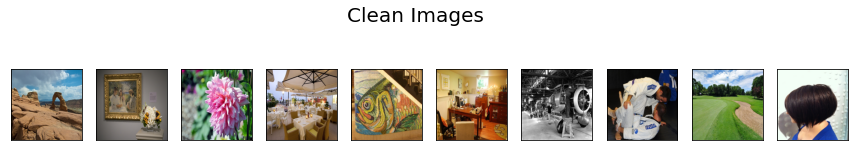

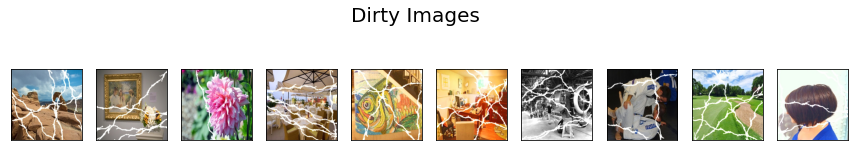

In [11]:
show_image_data(clean_images, title="Clean Images")
show_image_data(dirty_images, title="Dirty Images")

## Splitting the numpy arrays for training and validation.

In [12]:
train_clean_image = clean_images[:4000]
train_dirty_image = dirty_images[:4000]
val_clean_image = clean_images[4000:4500]
val_dirty_image = dirty_images[4000:4500]
test_clean_image = clean_images[4500:]
test_dirty_image = dirty_images[4500:]
print("train_clean_image", train_clean_image.shape)
print("train_dirty_image", train_dirty_image.shape)
print("val_clean_image", test_clean_image.shape)
print("val_dirty_image", test_dirty_image.shape)
print("test_clean_image", test_clean_image.shape)
print("test_dirty_image", test_dirty_image.shape)

train_clean_image (4000, 256, 256, 3)
train_dirty_image (4000, 256, 256, 3)
val_clean_image (500, 256, 256, 3)
val_dirty_image (500, 256, 256, 3)
test_clean_image (500, 256, 256, 3)
test_dirty_image (500, 256, 256, 3)


# Training the model.



In [13]:
AE.fit(train_dirty_image, 
       train_clean_image,
       epochs=10,
       shuffle=True,
       validation_data=(val_dirty_image, val_clean_image))

Epoch 1/10
125/125 [==============================] - 50s 152ms/step - loss: 6780.3437 - val_loss: 1759.7970
Epoch 2/10
125/125 [==============================] - 18s 142ms/step - loss: 1742.1048 - val_loss: 1493.6798
Epoch 3/10
125/125 [==============================] - 18s 142ms/step - loss: 1410.8517 - val_loss: 1300.8192
Epoch 4/10
125/125 [==============================] - 18s 142ms/step - loss: 1285.3831 - val_loss: 1206.2135
Epoch 5/10
125/125 [==============================] - 18s 141ms/step - loss: 1186.2740 - val_loss: 1185.7363
Epoch 6/10
125/125 [==============================] - 18s 142ms/step - loss: 1174.2678 - val_loss: 1150.0968
Epoch 7/10
125/125 [==============================] - 18s 142ms/step - loss: 1164.4392 - val_loss: 1119.5143
Epoch 8/10
125/125 [==============================] - 18s 142ms/step - loss: 1135.6593 - val_loss: 1092.0334
Epoch 9/10
125/125 [==============================] - 18s 142ms/step - loss: 1118.0566 - val_loss: 1087.3702
Epoch 10/10
125/125

# Viewing results.

In this section we will use the trained model to restore dirty image in our **test_dirty_image** array.

In [14]:
reconstructed_images = AE.predict(test_dirty_image)

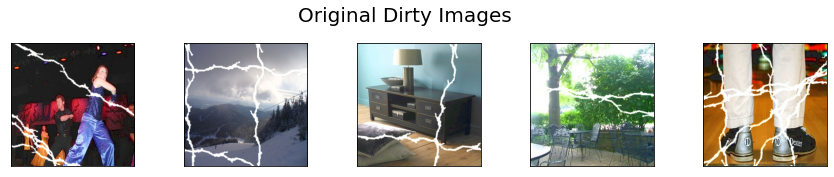

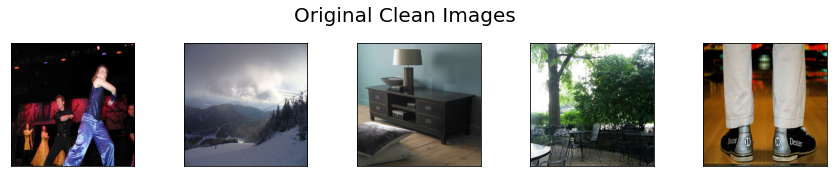

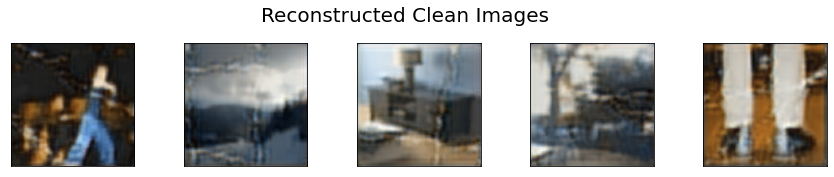

In [15]:
show_image_data(test_dirty_image, title="Original Dirty Images",n=5)
show_image_data(test_clean_image, title="Original Clean Images",n=5)
show_image_data(reconstructed_images, title="Reconstructed Clean Images",n=5)

# Model Evaluation using PSNR metrics.

PSNR stands for Peak Signal To Noise Ratio. Higher PSNR values equate to better restoration.


In [16]:
psnr = []

# calculating the PSNR values for each images in the test datset.
for i in range(len(reconstructed_images)):
  psnr.append(tf.image.psnr( reconstructed_images[i], test_clean_image[i], max_val=255).numpy())
  psnrs = np.array(psnr)

# printing out stats of psnr.
print("Mean PSNR: " + str(np.mean(psnrs)))
print("Median PSNR: " + str(np.median(psnrs)))
print("Maximum PSNR: " + str(np.amax(psnrs)))
print("Minimum PSNR: " + str(np.amin(psnrs)))

Mean PSNR: 6.0097685
Median PSNR: 5.5683937
Maximum PSNR: 16.13533
Minimum PSNR: 1.5130501


Normal distribution of PSNR values.

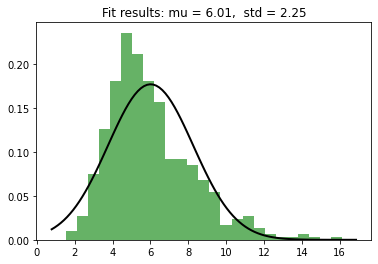

In [17]:
# (referenced from) https://stackoverflow.com/questions/20011122/fitting-a-normal-distribution-to-1d-data
from scipy.stats import norm
import matplotlib.pyplot as plt


# Generate some data for this demonstration.
data = psnrs

# Fit a normal distribution to the data:
mu, std = norm.fit(data)

# Plot the histogram.
plt.hist(data, bins=25, density=True, alpha=0.6, color='g')

# Plot the PDF.
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
plt.title(title)

plt.show()

**Conclusion:** SOTA papers have PSNR values of greater than 20 but we were only achive the mean PSNR of *6.01*. Since PSNR in in logarithmic form. This value is very low. 

# Saving and downloading model.

We have successfully trained our model to restore images. Now, we can deploy this model to create an web application that can restore images. So, we should save our model to deploy it in web application.

In [18]:
# save model
# we will be saving our models in both formats.
# AE.save('mymodel')

In [19]:
# AE.save('model.h5')

Now you can download these files from Google colab files explorer.

In [20]:
# !zip -r mymodel.zip mymodel